In [1]:
%matplotlib inline
import matplotlib
matplotlib.use("Agg")

import keras.utils
from keras import utils as np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
#from model.smallervggnet import SmallerVGGNet
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import argparse
import random
import pickle
import cv2
import os

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.6/dist-packages/tornado/platf

In [33]:
# import the necessary packages
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

#class SmallerVGGNet:
    #@staticmethod
def build_SmallerVGGNet(width, height, depth, classes):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1

        # CONV => RELU => POOL
        model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(3, 3)))
        model.add(Dropout(0.25))

        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(1024))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model

In [36]:
path_data= '../dataset/'
path_model_output='../models/lb3.model'
path_pickle= '../lb3.pickle'
path_plot= '../lb3.png'

In [35]:
# initialize the number of epochs to train for, initial learning rate,
# batch size, and image dimensions
EPOCHS = 40
INIT_LR = 1e-3
BS = 32
IMAGE_DIMS = (96, 96, 3)

# initialize the data and labels
data = []
labels = []

# grab the image paths and randomly shuffle them
print("[INFO] loading images...")
imagePaths = sorted(list(paths.list_images(path_data)))
random.seed(42)
random.shuffle(imagePaths)

# loop over the input images
for imagePath in imagePaths:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image)
    data.append(image)
 
    # extract the class label from the image path and update the
    # labels list
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("[INFO] data matrix: {:.2f}MB".format(
    data.nbytes / (1024 * 1000.0)))

# binarize the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
    labels, test_size=0.2, random_state=42)

[INFO] loading images...
[INFO] data matrix: 3007.58MB


In [37]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

# initialize the model
print("[INFO] compiling model...")
model2 = build_SmallerVGGNet(width=IMAGE_DIMS[1], height=IMAGE_DIMS[0],
    depth=IMAGE_DIMS[2], classes=len(lb.classes_))
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model2.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])

[INFO] compiling model...


[INFO] training network...
Epoch 1/40
348/348 [==============================] - 28s 81ms/step - loss: 0.7723 - acc: 0.7682 - val_loss: 1.3852 - val_acc: 0.7329
Epoch 2/40
348/348 [==============================] - 25s 73ms/step - loss: 0.4691 - acc: 0.8482 - val_loss: 0.3673 - val_acc: 0.8722
Epoch 3/40
348/348 [==============================] - 25s 73ms/step - loss: 0.3573 - acc: 0.8782 - val_loss: 0.3545 - val_acc: 0.8794
Epoch 4/40
348/348 [==============================] - 25s 72ms/step - loss: 0.3749 - acc: 0.8728 - val_loss: 0.1584 - val_acc: 0.9447
Epoch 5/40
348/348 [==============================] - 25s 72ms/step - loss: 0.2930 - acc: 0.8959 - val_loss: 0.2507 - val_acc: 0.9135
Epoch 6/40
348/348 [==============================] - 25s 71ms/step - loss: 0.2557 - acc: 0.9113 - val_loss: 0.3175 - val_acc: 0.8779
Epoch 7/40
348/348 [==============================] - 25s 72ms/step - loss: 0.2696 - acc: 0.9083 - val_loss: 0.2954 - val_acc: 0.9074
Epoch 8/40
348/348 [===============

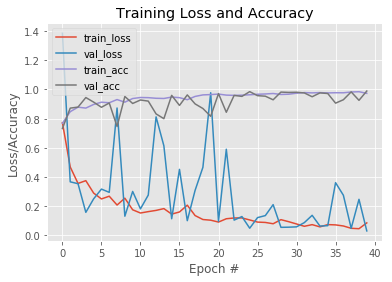

In [38]:
# train the network
print("[INFO] training network...")
H = model2.fit_generator(
    aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY),
    steps_per_epoch=len(trainX) // BS,
    epochs=EPOCHS, verbose=1)

# save the model to disk
print("[INFO] serializing network...")
model.save(path_model_output)

# save the label binarizer to disk
print("[INFO] serializing label binarizer...")
f = open(path_pickle, "wb")
f.write(pickle.dumps(lb))
f.close()

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.savefig(path_plot)

In [43]:
from sklearn.metrics import confusion_matrix

predY= model.predict(testX)
matrix = confusion_matrix(testY.argmax(axis=1), predY.argmax(axis=1))
print(matrix)

[[413   2   1   0   0   0   0]
 [ 27 584   2   3   1   0   0]
 [  0   0 365   1   0   0   0]
 [  0   0   0 530  24   0   0]
 [  1   0   0   2  57   0   0]
 [ 79  50   0   0   0 241   0]
 [  8 106   4   1   2   8 273]]


In [44]:
predY= model2.predict(testX)
matrix = confusion_matrix(testY.argmax(axis=1), predY.argmax(axis=1))
print(matrix)

[[416   0   0   0   0   0   0]
 [  7 609   0   0   0   1   0]
 [  0   0 366   0   0   0   0]
 [  0   0   0 553   1   0   0]
 [  0   0   0   0  60   0   0]
 [  0   0   0   0   0 368   2]
 [  0  14   0   0   0   5 383]]


In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_matrix(model,test_dataX, test_dataY, class_names, 
                           figsize = (10,7), fontsize=14):

    prediction= model.predict(test_dataX)
    matrix = confusion_matrix(test_dataY.argmax(axis=1), prediction.argmax(axis=1))
    df_cm = pd.DataFrame(matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

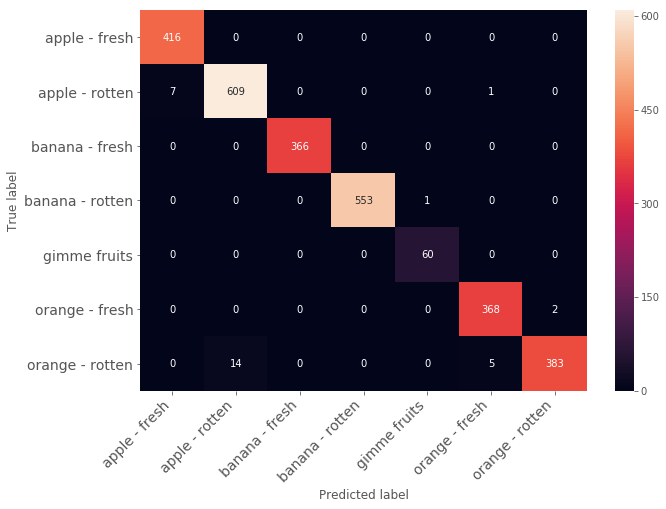

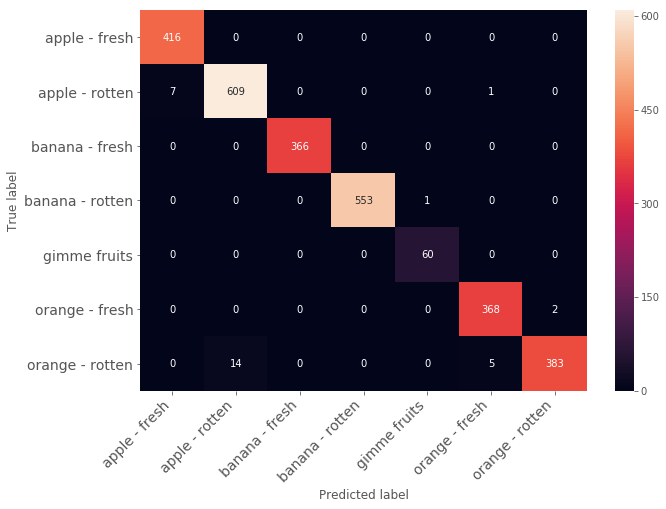

In [50]:
print_confusion_matrix(model=model2, test_dataX=testX, test_dataY=testY, class_names=lb.classes_)

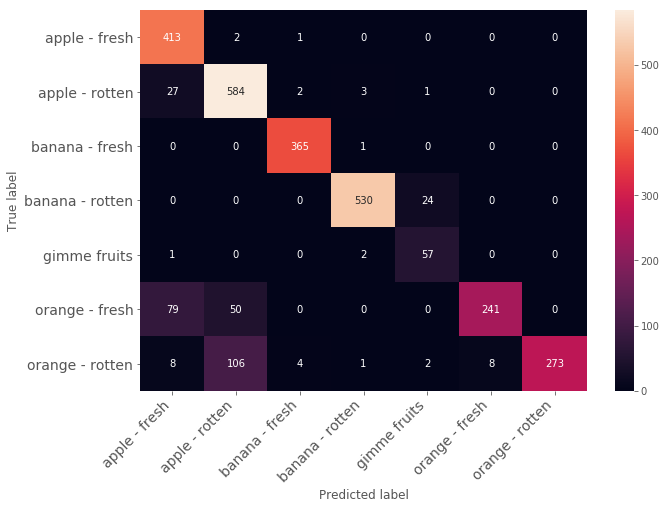

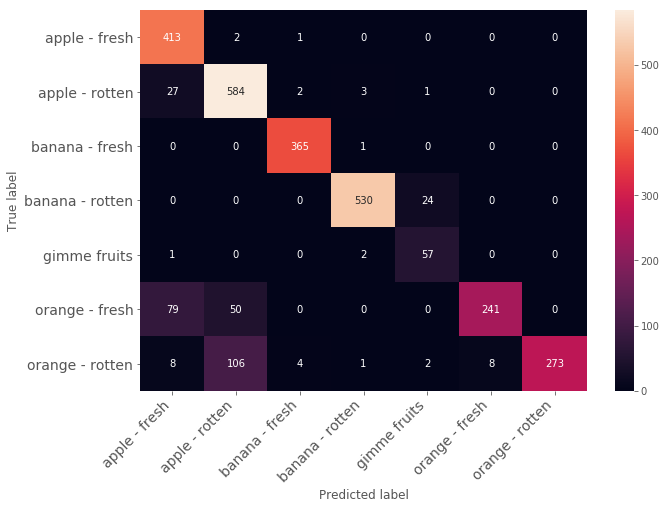

In [41]:
print_confusion_matrix(confusion_matrix=matrix, class_names=lb.classes_)